In [49]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as cts
import pylcp
import time
import random
from tqdm import tqdm
from scipy.interpolate import interp1d,interp2d,RegularGridInterpolator
from scipy import stats
from scipy import integrate
from celluloid import Camera
from bayes_opt import BayesianOptimization
import json
import seaborn as sns
import White_class
from scipy import special
import pymongo
import Expected_model_simulation
from pymongo import MongoClient
from scipy.optimize import root_scalar

In [33]:
# main_detune = 18.7
# sideband_detune = 120
# white_detune = 15
# beta_1 = 0.69
# beta_2 = 1.98
# laseron = 171312
# laseroff = 505566


# test = White_class.Whitelight(main_detune,sideband_detune,white_detune, beta_1,beta_2,laseron,laseroff)

In [34]:
#Main variables

main_detune = 17
sideband_detune = 120
white_detune = 10
laser_on = 200000
laser_off = 400015
MOT_power = 50
v0_start=1
v0_step=1
v0_end=25
t0_start=0
t0_step=1
t0_end=1000000


Gamma = 22 # Hz to kHz, Decay rate
wavelength = 359.3e-9 # m to mm
k = 1/wavelength*2*np.pi #x_0
x0 = 1/k
t0 = 1/Gamma*1/(2*np.pi*1e6)
v0 = x0/t0
m0 = cts.hbar*t0/x0**2
a0 = x0/t0**2
F0 = cts.hbar/(x0*t0)
mass = 43*cts.value('atomic mass constant')/m0 # m_0
mag_field_grad = 1252.8168984164048*x0
waist = 0.012/x0
v_max = 25.
z_max = 384.855e-3/x0
z_start = 384.855e-3/x0
omega = 2*np.pi*(cts.c/wavelength) #Transition frequency
Isat = np.pi*cts.h*cts.c*Gamma*2*np.pi*1e6/3*1/(wavelength)**3
t_eval = np.arange(t0_start,t0_end,t0_step)

# The detunings used in the PRAs:
intensities = 2.*MOT_power*1e-3/(np.pi*0.012**2)/Isat

#Define the hamiltonian
H0_X, Bq_X, U_X, Xbasis = pylcp.hamiltonians.XFmolecules.Xstate(N=1,I=0.5,B=15496.8125/Gamma,
gamma = 50.697/Gamma,b=154.7/Gamma, c=178.5/Gamma,gI=5.585,gS=2.0023193043622,
    muB = cts.value('Bohr magneton in Hz/T')/1e6*1e-4/Gamma,
    muN=cts.m_e/cts.m_p*cts.value('Bohr magneton in Hz/T')*1e-4*1e-6/Gamma,return_basis=True
    )

# b : SI coupling(isotropic), c : Iz Sz coupling(anisotropic), cc : I N coupling, gamma : S N coupling

E_X = np.unique(np.diag(H0_X))

H0_A, Bq_A, Abasis = pylcp.hamiltonians.XFmolecules.Astate(J=0.5,I=0.5,
    P=+1,B=15788.2/Gamma,D=0.,H=0.,a=0./Gamma,b=-0.4/Gamma,c=0.,q=0., p=15./Gamma,
    muB=cts.value('Bohr magneton in Hz/T')/1e6*1e-4/Gamma,
    muN=cts.m_e/cts.m_p*cts.value('Bohr magneton in Hz/T')*1e-4*1e-6/Gamma,return_basis=True
    )

# gJ : Lande g-factor, p : parity(e parity)

E_A = np.unique(np.diag(H0_A))

dijq = pylcp.hamiltonians.XFmolecules.dipoleXandAstates(
    Xbasis, Abasis, UX=U_X
    )

hamiltonian = pylcp.hamiltonian(H0_X, H0_A, Bq_X, Bq_A, dijq,mass = mass)

In [35]:
connection = MongoClient("localhost:27017")
db = connection.db.Expected_model
max_parameters = db.distinct(key = 'params',filter={'target' : {'$gte' : 0.06666}})

In [36]:
max_parameters

[{'beta_1': 0.6461462109437031,
  'beta_2': 3.563920913781865,
  'det_1': 117.99223775601251,
  'det_2': 5.669679716550722,
  'laseroff': 504757.18005055864,
  'laseron': 264356.89973333676,
  'main_det': 19.74010227764638}]

In [37]:
results = Expected_model_simulation.multi_motion_trace(**max_parameters[0])

test =list()

for sol in results:
    if len(sol.t_events[0])==1:
        test.append((sol.t[-1],sol.v[0][-1]))

100%|██████████| 8/8 [01:19<00:00,  9.94s/it]


In [38]:
test

[(1498198, 1.0636790519463346),
 (1210118, 1.1533756807574491),
 (930519, 1.2814199048660329),
 (681577, 1.4731781594226798),
 (482294, 1.9792643292607544),
 (382646, 4.212680469243289),
 (330030, 7.966841369461407),
 (308230, 13.508815022076432)]

In [50]:
z_range = np.linspace(0,12,13) # Unit : mm
vz_range = np.linspace(0,3,13) # Unit : Gamma/k
vc_range = np.linspace(1,7,13) # Unit : Gamma/k

Result_array = np.load("D:/migration/VC_finding_array.npy")

trap_lost = RegularGridInterpolator((z_range,vz_range,vc_range),Result_array[0])

def capture_condition(z,vz,vc):
    try:
        if vc<1 and vc>0:
            result = trap_lost([z,vz,1])[0]
        else:
            result = trap_lost([z,vz,vc])[0]
    except(ValueError):
        result = -1.
    finally:
        return result


def root_find(vz,tt,vc):
    return capture_condition(vz*tt*x0*1000,vz,vc)

def max_vz_calculator(tt,vc):
    max_vz = root_scalar(root_find,(tt,vc),method='bisect',bracket=[0,1])
    return max_vz

In [60]:
max_vz_calculator(*test[6])

ValueError: f(a) and f(b) must have different signs

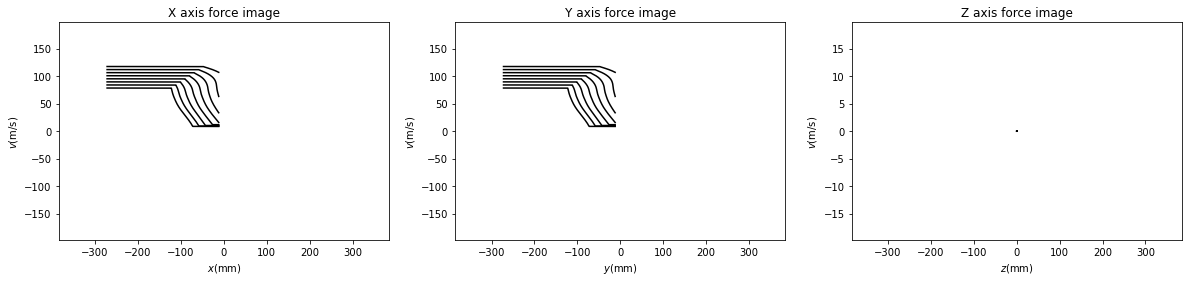

In [31]:
fig,ax = plt.subplots(1,3,figsize=(20,4))

ax[2].set_xlabel('$z (\mathrm{mm})$')
ax[2].set_ylabel('$v (\mathrm{m/s})$')
ax[2].set_title('Z axis force image')
ax[2].set_xlim(-1*z_max*x0*1000,z_max*x0*1000)
ax[2].set_ylim(-1*2.5*v0,1*2.5*v0)

ax[0].set_xlabel('$x (\mathrm{mm})$')
ax[0].set_ylabel('$v (\mathrm{m/s})$')
ax[0].set_title('X axis force image')
ax[0].set_xlim(-1*z_max*x0*1000,z_max*x0*1000)
ax[0].set_ylim(-1*v_max*v0,1*v_max*v0)

ax[1].set_xlabel('$y (\mathrm{mm})$')
ax[1].set_ylabel('$v (\mathrm{m/s})$')
ax[1].set_title('Y axis force image')
ax[1].set_xlim(-1*z_max*x0*1000,z_max*x0*1000)
ax[1].set_ylim(-1*v_max*v0,1*v_max*v0)
fig.subplots_adjust(left=0.12,right=0.9)

for sol in results:
    ax[0].plot(sol.r[0]*x0*1000,sol.v[0]*v0,color='black')
    ax[1].plot(sol.r[1]*x0*1000,sol.v[1]*v0,color='black')
    ax[2].plot(sol.r[2]*x0*1000,sol.v[2]*v0,color='black')

In [4]:
def Fixed_detune_MgF_MOT(main_det,det_1,det_2,beta_1,beta_2,laseron,laseroff):
    det_side = det_1/Gamma
    det_side2 = det_2/Gamma
    Avg_X = np.average(E_X)
    init_pow = 0.5*2./(np.pi*(0.012)**2)/Isat
    
    def Gaussian_Beam_Intensity(R,waist):
        return np.exp(-2*((R[0]-R[1])**2/2+R[2]**2)/waist**2)
    
    def Bessel_Intensity(n_order,beta):
        return special.jv(n_order,beta)**2
    
    def Heav_step(t):
        if laseron<=t and t<laseron+14:
            return -1*(t-laseron-7)*((t-laseron-7)**2-49*3)*1/686*1/2+1/2
        elif laseron+14<=t and t<laseroff:
            return 1
        elif t>=laseroff and t<laseroff+14:
            return (t-laseroff-7)*((t-laseroff-7)**2-49*3)*1/686*1/2 + 1/2
        else:
            return 0
        
    
    def pick_EOM(b):
        N_list = range(round(-b)-2,round(b)+2)
        order_list = list()
        # intensity_list = list()
        for n in N_list:
            temp = Bessel_Intensity(n,b)
            if temp>=0.01:
                order_list.append(n)
                # intensity_list.append(temp)
    
        # return order_list, intensity_list
        return order_list
    
    def laser_set(m,n):
        return pylcp.laserBeams([{'kvec':np.array([-1,-1,0]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+m*det_side+det_side2*n,
                                     's': lambda R,t : init_pow*Gaussian_Beam_Intensity(R,waist)*Heav_step(t)*Bessel_Intensity(m,beta_1)*Bessel_Intensity(n,beta_2)},
                                    {'kvec':np.array([-1,-1,0]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+m*det_side-det_side2*n,
                                     's': lambda R,t : init_pow*Gaussian_Beam_Intensity(R,waist)*Heav_step(t)*Bessel_Intensity(m,beta_1)*Bessel_Intensity(n,beta_2)}])
    
    
    white_order = pick_EOM(beta_2)
    
    laserBeams = pylcp.laserBeams()
    for m in {-1,0,1}:
        for n in white_order:
            laserBeams+=laser_set(m,n)

    return laserBeams

In [5]:
from scipy.interpolate import RegularGridInterpolator

xs = np.linspace(-0.4,0.4,101)/x0
ys = np.linspace(-0.4,0.4,101)/x0
zs = np.linspace(-0.2,0.2,101)/x0

X,Y,Z = np.meshgrid(xs,ys,zs,sparse=1,indexing="xy")
B = np.load("B_field_Interpolate.npy")

Bx = interp2d(xs,ys,B[0])
By = interp2d(xs,ys,B[1])



def B_func(R:np.array):
    if abs(R[2])>0.2/x0 or abs(R[1])>0.4/x0 or abs(R[0])>0.4/x0:
        return np.zeros(3,)
    return np.concatenate((Bx(R[0],R[1]),By(R[0],R[1]),np.zeros(1,)),axis=0)

In [6]:
def slow_bayesian(main_det,det_1,det_2,beta_1,beta_2,laseron,laseroff):
    magField = lambda R,t : B_func(R)
    laserBeams = Fixed_detune_MgF_MOT(main_det,det_1,det_2,beta_1,beta_2,laseron,laseroff)
    rateeq = pylcp.rateeq(laserBeams=laserBeams,magField=magField,hamitlonian=hamiltonian)

    
    # def Capture_velocity_condition(t,y,threshold = 5.810/np.sqrt(2)):
    #     if y[-6]<threshold:
    #         val = -1.
    #     else:
    #         val = 1.
    #     return val
    def Lost_condition(t,y,threshold = 0.):
        if y[-6]<threshold:
            val = -1.
        else:
            val = 1.
        return val
    def for_transverse_condition(t,y,threshold = -0.012/x0):
        if y[-3]>threshold:
            val = -1.
        else:
            val = 1.
        return val

    # Capture_velocity_condition.terminal = True
    Lost_condition.terminal = True
    for_transverse_condition.terminal = True
    # conditions =  [for_transverse_condition,Lost_condition,Capture_velocity_condition]
    conditions =  [for_transverse_condition,Lost_condition]    
    v_longitudinal = np.linspace(14,21,16)
    time_final = list()
    v_trap_initial = list()
    
    for v0_longitudinal in v_longitudinal:
        rateeq.set_initial_position_and_velocity(np.array([-1*z_start/np.sqrt(2),-1*z_start/np.sqrt(2),0]),np.array([v0_longitudinal/np.sqrt(2),v0_longitudinal/np.sqrt(2),0]))
        rateeq.set_initial_pop(np.array([1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0]))

        rateeq.evolve_motion([0.,max(t_eval)],t_eval=t_eval,events= conditions,max_step=1e5,progress_bar = 0,method='LSODA')
        sol = rateeq.sol
        # print(sol.t_events)
        if len(sol.t_events[0])==1:
            if len(sol.t_events[1])==0:
                if sol.v[0,-1]<5.810/np.sqrt(2):
                    time_final.append(sol.t[-1])
                    v_trap_initial.append(v0_longitudinal)
                
            
            
                    
    # print(v_trap_initial)
    # print(time_final)
                    
    if len(time_final)<=1:
        # print("NO results")
        return 0.
    
    def time_vs_v_final(vff):
        if vff>= min(v_trap_initial) and vff<=max(v_trap_initial):
            return np.interp(vff,v_trap_initial,time_final)

    def v_transverse_vs_v_traverse(vfs):
        return (6.00/time_vs_v_final(vfs)*1e-3/t0)

    muf = 140/v0
    sigf = 17/v0
    mut = 0
    sigt = 18.7564/v0

    def Transverse_percentage(v):
        rv = stats.norm(mut,sigt) # Gaussian of transverse, v0 scale
        val = (rv.cdf(v_transverse_vs_v_traverse(v))-rv.cdf(0))/rv.cdf(sigt*2)*2

        if val >= 1:
            return 1
        else:
            return val

    def total_func(v):
        rv_f = stats.norm(muf,sigf) # Gaussian of forward, v0 scale
        return Transverse_percentage(v)*rv_f.pdf(v)

    return integrate.quad(total_func,v_trap_initial[0],v_trap_initial[-1],limit=100)[0]

In [51]:
start = time.time()

print(slow_bayesian(18.7,120,15,0.69,1.98,171312,505566))

print(time.time()-start)

Completed in 6.13 s.                                                
Completed in 6.50 s.                                               
Completed in 7.00 s.                                               
Completed in 7.22 s.                                                
Completed in 8.96 s.                                               
Completed in 8.53 s.                                               
Completed in 8.91 s.                                               
Completed in 11.03 s.                                              
Completed in 9.44 s.                                               
Completed in 9.50 s.                                               
Completed in 10.45 s.                                              
Completed in 12.23 s.                                               
Completed in 11.57 s.                                               
Completed in 13.71 s.                                               
Completed in 14.28 s.                      

In [7]:
pbounds = {'main_det':(10,20),'det_1':(70,170),'det_2':(5,30),'beta_1':(0,5),'beta_2':(0,15),'laseron':(138240,300000),'laseroff':(300001,600000)}

In [8]:
optimizer = BayesianOptimization(
    f = slow_bayesian,
    pbounds=pbounds,
    verbose=13,
    random_state=1,
)

In [9]:
from bayes_opt.util import load_logs

# New optimizer is loaded with previously seen points
load_logs(optimizer, logs=["./logs_0407.json"])

In [59]:
start = time.time()
optimizer.maximize(
    init_points=1,
    n_iter=0,)
print(time.time()-start)

|   iter    |  target   |  beta_1   |  beta_2   |   det_1   |   det_2   | laseroff  |  laseron  | main_det  |
-------------------------------------------------------------------------------------------------------------
|  1        |  0.04677  |  2.085    |  10.8     |  70.01    |  12.56    |  3.44e+05 |  1.532e+0 |  11.86    |
248.13847947120667


In [60]:
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events

logger = JSONLogger(path='./logs_0407.json')
optimizer.subscribe(Events.OPTIMIZATION_STEP,logger)

In [61]:
start = time.time()
optimizer.maximize(
    init_points=5,
    n_iter=10,)
print(time.time()-start)

|   iter    |  target   |  beta_1   |  beta_2   |   det_1   |   det_2   | laseroff  |  laseron  | main_det  |
-------------------------------------------------------------------------------------------------------------
|  2        |  0.0      |  1.728    |  5.952    |  123.9    |  15.48    |  5.056e+0 |  1.713e+0 |  18.78    |
|  3        |  0.02726  |  0.1369   |  10.06    |  111.7    |  18.97    |  3.421e+0 |  1.703e+0 |  18.01    |
|  4        |  0.0      |  4.841    |  4.701    |  139.2    |  26.91    |  5.684e+0 |  1.52e+05 |  10.39    |
|  5        |  0.0      |  0.8492   |  13.17    |  79.83    |  15.53    |  5.874e+0 |  2.245e+0 |  16.92    |
|  6        |  0.0473   |  1.578    |  10.3     |  153.5    |  5.457    |  5.25e+05 |  2.982e+0 |  17.48    |
|  7        |  0.0      |  1.12     |  14.5     |  123.4    |  23.71    |  5.496e+0 |  1.88e+05 |  15.54    |
|  8        |  0.0      |  0.5403   |  9.576    |  141.3    |  18.9     |  3.72e+05 |  1.397e+0 |  12.15    |
|  9      

In [10]:
start = time.time()
optimizer.maximize(
    init_points=0,
    n_iter=30,)
print(time.time()-start)

|   iter    |  target   |  beta_1   |  beta_2   |   det_1   |   det_2   | laseroff  |  laseron  | main_det  |
-------------------------------------------------------------------------------------------------------------
|  1        |  0.0      |  2.646    |  7.78     |  155.1    |  14.86    |  3.28e+05 |  2.377e+0 |  10.4     |
|  2        |  0.0      |  3.826    |  1.643    |  122.2    |  24.21    |  5.061e+0 |  1.598e+0 |  12.02    |
|  3        |  0.01639  |  2.883    |  3.271    |  135.7    |  14.08    |  3.042e+0 |  2.007e+0 |  14.02    |
|  4        |  0.2334   |  1.615    |  10.69    |  118.0    |  5.67     |  5.048e+0 |  2.644e+0 |  19.74    |
|  5        |  0.0      |  2.207    |  7.635    |  128.4    |  25.99    |  3.008e+0 |  2.706e+0 |  11.11    |
|  6        |  0.02142  |  0.1765   |  10.53    |  151.0    |  16.91    |  3.743e+0 |  2.611e+0 |  10.2     |
|  7        |  0.1048   |  4.625    |  12.57    |  70.76    |  27.36    |  3.016e+0 |  2.205e+0 |  14.44    |
|  8      

C:\Users\qmopl\AppData\Local\Temp/ipykernel_10708/3589849535.py:83: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return integrate.quad(total_func,v_trap_initial[0],v_trap_initial[-1],limit=100)[0]


|  29       |  0.2944   |  3.805    |  9.937    |  87.6     |  25.53    |  4.919e+0 |  1.623e+0 |  19.47    |
|  30       |  0.0      |  3.157    |  12.44    |  145.8    |  26.19    |  4.12e+05 |  2.233e+0 |  11.68    |
4919.5048615932465


In [15]:
optimizer.maximize(n_iter=1,init_points = 0)

|   iter    |  target   |  beta_1   |  beta_2   |   det_1   |   det_2   | laseroff  |  laseron  | main_det  |
-------------------------------------------------------------------------------------------------------------
|  53       |  0.002721 |  4.385    |  0.326    |  116.6    |  15.66    |  4.285e+0 |  2.125e+0 |  18.62    |


In [11]:
optimizer.max

{'target': 0.2944409759829353,
 'params': {'beta_1': 3.8050995873529567,
  'beta_2': 9.936559576119455,
  'det_1': 87.59839010311943,
  'det_2': 25.530476380724924,
  'laseroff': 491912.16996315226,
  'laseron': 162300.30234814572,
  'main_det': 19.47056298409516}}